# Modelo SIR

Arthur Souto Lima  
Vitória Mirella Pereira do Nascimento

## Algoritmos

### Imports 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from numba import jit

sns.set_theme()
sns.set_palette("colorblind")

### Funções de Plotting

Para podermos ver a evolução da infecção na rede, temos que conseguir plotá-la. O código de cores é simples: azuis são os suscetíveis, vermelhos são os infectados e verdes são os recuperados.

In [2]:
from matplotlib.colors import LinearSegmentedColormap

def plot_map(s, L, title=None):
    """
    Plota uma rede de autômatos LxL no estado s
    
    Parâmetros:
        s: estado dos autômatos
        L: tamanho do quadrado da rede
        title: (opcional) título do plot
    Retornos:
        None
    """
    # Transforma o vetor em matriz
    s1 = s.reshape(L,L)
    s2 = np.flip(s1,0)

    # Plot
    resize_factor = L/100
    base_factor = 3
    plt.figure(figsize=(base_factor*resize_factor,
                        base_factor*resize_factor))
    colors = ['b','r','g']
    cmap = LinearSegmentedColormap.from_list('cmap', colors, N=3)
    plt.imshow(s2, cmap=cmap)
    plt.grid(False)
    plt.xticks([],[])
    plt.yticks([],[])
    
    # Coloca título
    if (title is not None):
        plt.title(title)

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

### Funções Auxiliares

Vamos usar interface parecida com a que usamos nas atividades do Modelo de Ising. Assim, a rede de autômatos será guardada num array de $ N $ posições e a vizinhança será feita através de uma matriz.

In [3]:
@jit(nopython=True)
def neighbours(N, L):
    """
    Constrói a matriz de vizinhança.
    Assume que há uma "vizinhança circular" como se a rede 
    fosse um toro.
    Adaptação do algoritmo proposto no enunciado da atividade
    Wang-Landau
    """
    # Cria uma matriz Nx4
    viz = np.zeros((N,4), dtype=np.longlong)

    # (k,0): vizinho à direita
    # (k,1): vizinho acima
    # (k,2): vizinho à esquerda
    # (k,3): vizinho abaixo]
    for k in range(N):
        # Vizinho à direita (k,0)
        viz[k][0] = k+1
        if (k % L == L-1):
            # Sítio na borda da direita
            viz[k][0] = k+1-L

        # Vizinho acima (k,1)
        viz[k][1] = k+L
        if (k >= N-L):
            # Sítio na borda superior
            viz[k][1] = k+L-N

        # Vizinho à esquerda (k,2)
        viz[k][2] = k-1
        if (k % L == 0):
            # Sítio na borda da esquerda
            viz[k][2] = k+L-1

        # Vizinho abaixo (k,3)
        viz[k][3] = k-L
        if (k < L):
            # Sítio na borda inferior
            viz[k][3] = k+N-L
    return viz

Para propiciar estados iniciais, podemos criar uma função que infecta $ k $ pessoas numa rede em que todas ainda estavam apenas suscetíveis.

In [4]:
@jit(nopython=True)
def random_infected(N, n_infected):
    """
    Gera um estado de epidemia com alguns sítios
    aleatórios considerados como infectados
    """
    # Gera N sítios suscetíveis
    # De 0 a N-1
    s = []
    for i in range(N):
        s.append(0)
    s = np.array(s)
    
    # Infecta n_infected sítios
    while (s.sum() < n_infected):
        i = np.random.randint(0, N)
        s[i] = 1
    return s

<br>
<br>
<br>

Durante as simulações, temos que, diversas vezes, fazer contagens de 0's, 1's e 2's em arrays, os quais representam, respectivamente, suscetíveis, infectados e recuperados na rede de autômatos.

In [5]:
@jit(nopython=True)
def count(s):
    """
    Conta quantos 0's, 1's e 2's tem no array
    
    Parâmetros:
        s: array com apenas 0,1 e 2
    Retorno:
        hist: tupla com quantidades de 0's, 1's e 2's, 
            respectivamente
    """
    hist = [0,0,0]
    for i in range(len(s)):
        hist[s[i]] += 1
    return hist

Como cada iteração da simulação pode parar após uma quantidade diferente de instantes de tempo, temos que ser capazes de tirar a média de arrays de tamanhos diferentes. Para tanto, vamos interpolá-los para que fiquem do mesmo tamanho.

In [8]:
import numpy as np
from scipy.ndimage import zoom

def zoom_interpolate(A, B):
    """
    Interpola o array A para que tenha a mesma quantidade de elementos de B
    
    Parâmetros:
        A: vetor a ser interpolado
        B: vetor com quantidade objetivo de elementos
    Retorno:
        C: vetor A interpolado com len(B) elementos
    
    """
    zoom_rate = B.shape[0] / A.shape[0]
    C = zoom(A, zoom_rate)
    return C

Usando a interpolação, vamos somar arrays de tamanhos diferentes

In [10]:
def sum_different(a,b):
    """
    Soma os arrays a e b não simétricos
    
    Parâmetros:
        a,b: arrays
    Retornos:
        c = a + b
    """
    if len(a) < len(b):
        c = zoom_interpolate(a,b)
        return c + b
    else:
        c = zoom_interpolate(b,a)
        return a + c

Finalmente, podemos simular a epidemia, usando as probabilidades de que um infectado contamine algum suscetível ($ p_c $) e que um infectado se recupere ($ p_r $).

<br>
<br>
<br>
<br>
<br>
<br>

### Funções de Simulação

Assim, podemos definir a função que simula uma epidemia via modelo SIR.

In [6]:
def simulate_epidemy(N, L, s, pc, pr, n_iter, prints=False, print_states=False):
    """
    Simula uma epidemia segundo o modelo SIR numa rede de
    N autômatos celulares, organizados de forma quadrada (LxL),
    e com vizinhança circular.
    
    Parâmetros:
        N: quantidade de autômatos celulares
        L: lado do quadrado da rede (N = L*L)
        s: estado inicial
        pc: probabilidade de contaminação
        pr: probabilidade de recuperação
        n_iter: quantidade de iterações
        prints: se verdadeiro, imprimirá resultados intermediários
    
    Retornos:
        suscp_t: lista com quantidade de suscetíveis a cada momento
        infec_t: lista com quantidade de infectados a cada momento
        recup_t: lista com quantidade de recuperados a cada momento
        ts: iterações
    """
    assert N == L**2
    viz = neighbours(N,L)

    
    suscp_t = []
    infec_t = []
    recup_t = []
    ts = []
    
    
    for n in range(n_iter):
        distribution = count(s)
        if (distribution[1] == 0):
            print("Não há mais infectados. Iteração: ", n)
            break
        
        if (n % 20 == 0 and print_states == True):
            plot_map(s, L, title=("Iteração "+str(n)))
            plt.show()
        elif (n % 20 == 0 and print_states == False):
            print("Iteração "+str(n))
        
        # Para cada autômato da rede
        for i in range(N):
            if (s[i] == 1):
                # Contaminada
                if (np.random.random() < pr):
                    # Chance de se recuperar
                    if (prints): print(i,"recuperado")
                    s[i] = 2
                else:
                    viz_k = viz[i]
                    for j in viz_k:
                        if (s[j] == 0):
                            if (np.random.random() < pc):
                                # Chance de contaminar a outra
                                if (prints): print(j,"contaminado por ", i)
                                s[j] = 1
            elif (s[i] == 2):
                # Recuperada
                pass
            else:
                # Suscetível
                pass
            
            distribution = count(s)
            suscp_t.append(distribution[0])
            infec_t.append(distribution[1])
            recup_t.append(distribution[2])
            ts.append(i)
    return suscp_t, infec_t, recup_t, ts

<br>
<br>
<br>
<br>

Finalmente, como esse é um método estocástico, temos que avaliar a média de várias rodadas.

In [7]:
def simulate(L, infected, pc, pr, s=None, qtd=5):
    """
    Simula vários modelos SIR e retorna a média deles 
    """
    # Parâmetros
    N = L**2
    if (s is None):
        s = random_infected(N, infected)
    
    # Vetores para guardar
    suscp_total = np.zeros(1, dtype=np.int64)
    infec_total = np.zeros(1, dtype=np.int64)
    recup_total = np.zeros(1, dtype=np.int64)
    
    for i in range(qtd):
        print("Rodada "+str(i))
        s0 = s.copy()
        sus, inf, rec, _ = simulate_epidemy(N, L, s0, pc, pr, n_iter=10**4)
        sus = np.array(sus, dtype=np.int64)
        inf = np.array(inf, dtype=np.int64)
        rec = np.array(rec, dtype=np.int64)
        suscp_total = sum_different(suscp_total, sus)
        infec_total = sum_different(infec_total, inf)
        recup_total = sum_different(recup_total, rec)
        
    factor = 1/qtd
    
    suscp_total = np.array(suscp_total) * factor
    infec_total = np.array(infec_total) * factor
    recup_total = np.array(recup_total) * factor
    
    return suscp_total,infec_total,recup_total

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

## Simulações

Nesta seção de simulações, vamos explorar algumas situações e observar o comportamento da rede à epidemia. 

### Poucos indivíduos aleatórios contaminados

#### Uma iteração

Vamos olhar uma rede 100x100. Inicialmente, podemos observar uma iteração, para analisarmos o comportamento dela preliminarmente. Começaremos com 4 indivíduos aleatoriamente escolhidos infectados.

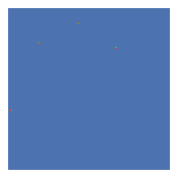

In [11]:
L = 100
N = L**2
s = random_infected(N, 4)
plot_map(s, L)

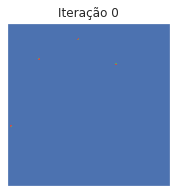

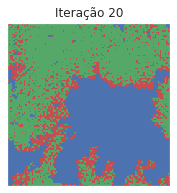

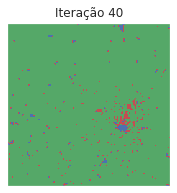

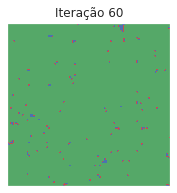

Não há mais infectados. Iteração:  63


In [12]:
y0, y1, y2, x = simulate_epidemy(N, L, s, 0.6, 0.2, n_iter=10**4, print_states=True)

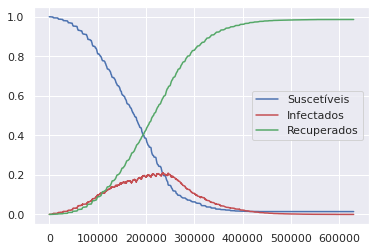

In [13]:
plt.plot(np.array(y0)/N, color='b')
plt.plot(np.array(y1)/N, color='r')
plt.plot(np.array(y2)/N, color='g')
plt.legend(["Suscetíveis","Infectados","Recuperados"])

O comportamento é o esperado, os infectados aumentam até um pico, quando passam a decrescer até zerarem. Os recuperados, por outro lado, tomam maioria da população suscetível.


Contudo, esse resultado é apenas para uma iteração e, como temos um método estocástico, regido por variáveis aleatórias, convém fazer mais de uma simulação para melhor embasar as análises.

#### Média das iterações

In [14]:
y0, y1, y2 = simulate(L, infected=4, s=None, pc=0.6, pr=0.2)

Rodada 0
Iteração 0
Iteração 20
Iteração 40
Não há mais infectados. Iteração:  55
Rodada 1
Iteração 0
Iteração 20
Iteração 40
Iteração 60
Não há mais infectados. Iteração:  62
Rodada 2
Iteração 0
Iteração 20
Iteração 40
Não há mais infectados. Iteração:  57
Rodada 3
Iteração 0
Iteração 20
Iteração 40
Não há mais infectados. Iteração:  55
Rodada 4
Iteração 0
Iteração 20
Iteração 40
Iteração 60
Não há mais infectados. Iteração:  64


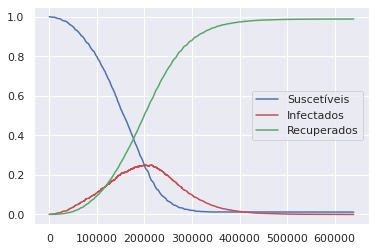

In [15]:
plt.plot(np.array(y0)/N, color='b')
plt.plot(np.array(y1)/N, color='r')
plt.plot(np.array(y2)/N, color='g')
plt.legend(["Suscetíveis","Infectados","Recuperados"])

Nota-se que nessa configuração, toda a população é contaminada, mas se recupera. Em um determinado ponto, os infectados chegaram a cerca de 30% da população no pico. Com o passar das iterações, já que não há nem recontaminação nem óbitos a população se recupera e fica imune, causando o fim da infecção.

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

#### Maior taxa de recuperação

In [16]:
y0, y1, y2 = simulate(L, infected=4, s=None, pc=0.6, pr=0.3)

Rodada 0
Iteração 0
Iteração 20
Iteração 40
Iteração 60
Iteração 80
Não há mais infectados. Iteração:  100
Rodada 1
Iteração 0
Iteração 20
Iteração 40
Iteração 60
Iteração 80
Iteração 100
Não há mais infectados. Iteração:  106
Rodada 2
Iteração 0
Iteração 20
Iteração 40
Iteração 60
Iteração 80
Não há mais infectados. Iteração:  97
Rodada 3
Iteração 0
Iteração 20
Iteração 40
Iteração 60
Iteração 80
Iteração 100
Iteração 120
Iteração 140
Iteração 160
Iteração 180
Não há mais infectados. Iteração:  186
Rodada 4
Iteração 0
Iteração 20
Iteração 40
Iteração 60
Iteração 80
Iteração 100
Iteração 120
Iteração 140
Não há mais infectados. Iteração:  156


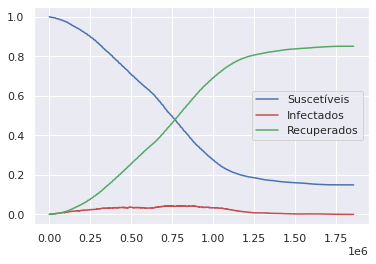

In [17]:
plt.plot(np.array(y0)/N, color='b')
plt.plot(np.array(y1)/N, color='r')
plt.plot(np.array(y2)/N, color='g')
plt.legend(["Suscetíveis","Infectados","Recuperados"])

Se incrementarmos a taxa de recuperação, nota-se que a infecção é muito menor, de forma que há aqueles indivíduos que nem se contaminam. Além disso, a curva de infecções é bem mais suave, com pico muito baixo. Pode ser por conta da sequência de números aleatórios, mas todas as rodadas nesse cenário demoraram bem mais iterações para estabilizar, ou seja, para que a infeccção termine.

#### Maior taxa de infecção

In [18]:
y0, y1, y2 = simulate(L, infected=4, s=None, pc=0.8, pr=0.2)

Rodada 0
Iteração 0
Iteração 20
Iteração 40
Não há mais infectados. Iteração:  46
Rodada 1
Iteração 0
Iteração 20
Iteração 40
Não há mais infectados. Iteração:  49
Rodada 2
Iteração 0
Iteração 20
Iteração 40
Iteração 60
Não há mais infectados. Iteração:  64
Rodada 3
Iteração 0
Iteração 20
Iteração 40
Não há mais infectados. Iteração:  44
Rodada 4
Iteração 0
Iteração 20
Iteração 40
Não há mais infectados. Iteração:  45


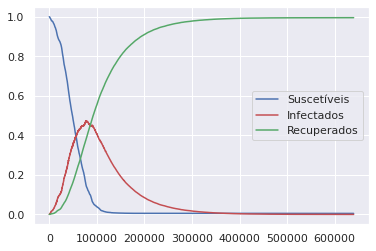

In [19]:
plt.plot(np.array(y0)/N, color='b')
plt.plot(np.array(y1)/N, color='r')
plt.plot(np.array(y2)/N, color='g')
plt.legend(["Suscetíveis","Infectados","Recuperados"])

Nesse cenário, a infeccção é mais rápida e o pico da infeccção é maior, com cerca de 40% ou 50% da população contaminada num determinado momento. Novamente, como não há outras possibilidades para os indíviduos, como recontaminação ou vacinação, a população se contamina muito rápido e logo a epidemia termina, pois todos se recuperam da doença e ela não circula mais.

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

### Porcentagem mais alta de contaminados

#### 10% aleatórios contaminados

Estávamos utilizando um número absoluto e baixo de pessoas inicialmente infectadas aleatoriamente. Nessa segunda etapa de simulações vamos analisar o efeitod e uma quantidade maior de indivíduos inicialmente contaminados.

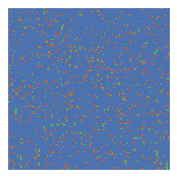

In [20]:
L = 100
N = L**2
infected = .1*N
s = random_infected(N, infected)
plot_map(s, L)

In [21]:
y0, y1, y2 = simulate(L, infected=infected, s=None, pc=0.6, pr=0.2)

Rodada 0
Iteração 0
Iteração 20
Não há mais infectados. Iteração:  38
Rodada 1
Iteração 0
Iteração 20
Não há mais infectados. Iteração:  40
Rodada 2
Iteração 0
Iteração 20
Iteração 40
Não há mais infectados. Iteração:  44
Rodada 3
Iteração 0
Iteração 20
Iteração 40
Não há mais infectados. Iteração:  41
Rodada 4
Iteração 0
Iteração 20
Não há mais infectados. Iteração:  40


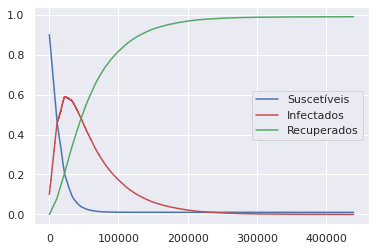

In [22]:
plt.plot(np.array(y0)/N, color='b')
plt.plot(np.array(y1)/N, color='r')
plt.plot(np.array(y2)/N, color='g')
plt.legend(["Suscetíveis","Infectados","Recuperados"])

Comparando com o exemplo anterior, além, obviamente, dos pontos iniciais das curvas, vemos que a infeccção tem um pico bem maior, de forma que atinge 60% da população num dado momento.

<br>
<br>
<br>
<br>

#### 40% aleatórios contaminados

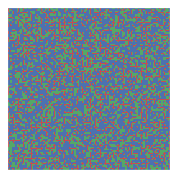

In [23]:
L = 100
N = L**2
infected = .4*N
s = random_infected(N, infected)
plot_map(s, L)

In [24]:
y0, y1, y2 = simulate(L, infected=infected, s=None, pc=0.6, pr=0.2)

Rodada 0
Iteração 0
Iteração 20
Iteração 40
Não há mais infectados. Iteração:  54
Rodada 1
Iteração 0
Iteração 20
Não há mais infectados. Iteração:  38
Rodada 2
Iteração 0
Iteração 20
Iteração 40
Não há mais infectados. Iteração:  48
Rodada 3
Iteração 0
Iteração 20
Iteração 40
Não há mais infectados. Iteração:  42
Rodada 4
Iteração 0
Iteração 20
Iteração 40
Não há mais infectados. Iteração:  50


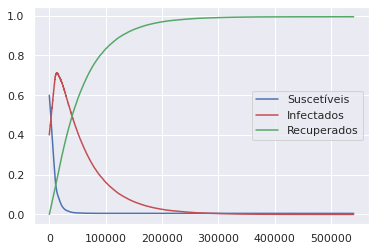

In [25]:
plt.plot(np.array(y0)/N, color='b')
plt.plot(np.array(y1)/N, color='r')
plt.plot(np.array(y2)/N, color='g')
plt.legend(["Suscetíveis","Infectados","Recuperados"])

O pico de infecções fica ainda maior quando 40% da população está inicialmente contaminada.

<br>
<br>
<br>
<br><br>
<br>
<br>
<br><br>

## Conclusões

Ao final dessa breve exploração do modelo SIR para epidemias em autômatos celulares, é possível notar que o modelo, mesmo sendo bem simples de entender e implementar, consegue capturar várias dinâmicas da infecção de uma população. Entretando, apesar disso, a versão implementada, seguindo os moldes do enunciado, é bem limitada, já que outros fatores tão comuns e relevantes nesse tipo de análise não são modelados, como vacinação, eficácia delas contra reinfecção, reinfecção de já recuperados e até mesmo óbitos. Essas situações dariam mais poder de modelagem, ao custo de maior complexidade e certamente de maior custo computacional.